In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fde345d8ef0>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
train_data[:5] # 상위 5개 출력
# label : 긍정(1), 부정(0)

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 146183


   label  count
0      0  73342
1      1  72841


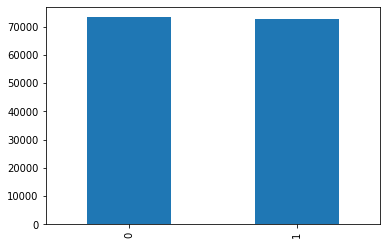

In [5]:
# 긍정,부정 분포도
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))


In [6]:
#리뷰 중 null값 있는지 확인
print(train_data.isnull().values.any()) # Null값 제거 전
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

True
False


In [7]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [8]:
# white space 데이터를 empty value로 변경 
train_data['document'] = train_data['document'].str.replace('^ +', "") 
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거

print(train_data.isnull().sum())


id          0
document    0
label       0
dtype: int64


In [9]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 48852


In [10]:
## TOKENIZER
#불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [11]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)


In [12]:
print(X_train[:3])

X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
    
print(X_test[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]
[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


In [13]:
# Make Vocaburary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test) # 훈련데이터셋 사용
print(tokenizer.word_index)



{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '만': 13, '진짜': 14, '적': 15, '같다': 16, '아니다': 17, '로': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '평점': 23, '나오다': 24, '연기': 25, '것': 26, '내': 27, '최고': 28, '그': 29, '인': 30, '안': 31, '나': 32, '생각': 33, '게': 34, '못': 35, '왜': 36, '스토리': 37, '드라마': 38, '사람': 39, '감동': 40, '보고': 41, '때': 42, '이렇다': 43, '더': 44, '고': 45, '아깝다': 46, '말': 47, '감독': 48, '배우': 49, 'ㅋㅋ': 50, '아': 51, '그냥': 52, '내용': 53, '거': 54, '중': 55, '까지': 56, '재미있다': 57, '재미': 58, '시간': 59, '주다': 60, '요': 61, '자다': 62, '재미없다': 63, '뭐': 64, '하고': 65, '지루하다': 66, '가다': 67, '수': 68, '네': 69, '들다': 70, '쓰레기': 71, '사랑': 72, '그렇다': 73, '모르다': 74, '볼': 75, '싶다': 76, '작품': 77, '지': 78, '알다': 79, '다시': 80, '하나': 81, '마지막': 82, 'ㅠㅠ': 83, '이건': 84, '저': 85, '오다': 86, '정도': 87, '많다': 88, '완전': 89, '처음': 90, 'ㅋ': 91, '장면': 92, '주인공': 93, 'ㅋㅋㅋ': 94, '나다': 95, '이렇게': 96, '액션': 97, '안되다': 98, '차다': 99, '하': 100, '최악': 101, '걸': 

In [14]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26774
등장 빈도가 2번 이하인 희귀 단어의 수: 15878
단어 집합에서 희귀 단어의 비율: 59.30380219616045
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.670480839329297


In [15]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 10897


In [16]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])


[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [17]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [18]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))


145007
145007


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.57053797402884


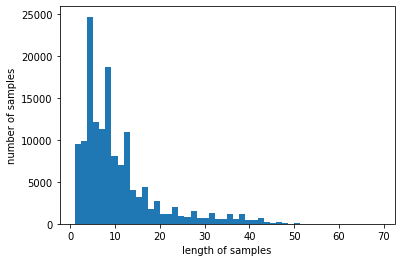

In [19]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
max_len = 30
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.6706021088637


In [22]:
#LSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [23]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [25]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1933/1934 [============================>.] - ETA: 0s - loss: 0.3919 - acc: 0.8216
Epoch 00001: val_acc improved from -inf to 0.84508, saving model to best_model.h5
1934/1934 [==============================] - 69s 36ms/step - loss: 0.3919 - acc: 0.8216 - val_loss: 0.3507 - val_acc: 0.8451
Epoch 2/15
1934/1934 [==============================] - ETA: 0s - loss: 0.3296 - acc: 0.8562
Epoch 00002: val_acc improved from 0.84508 to 0.85563, saving model to best_model.h5
1934/1934 [==============================] - 68s 35ms/step - loss: 0.3296 - acc: 0.8562 - val_loss: 0.3353 - val_acc: 0.8556
Epoch 3/15
1934/1934 [==============================] - ETA: 0s - loss: 0.3067 - acc: 0.8687
Epoch 00003: val_acc improved from 0.85563 to 0.85784, saving model to best_model.h5
1934/1934 [==============================] - 68s 35ms/step - loss: 0.3067 - acc: 0.8687 - val_loss: 0.3316 - val_acc: 0.8578
Epoch 4/15
1933/1934 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.8772
E

In [26]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 11s 7ms/step - loss: 0.3435 - acc: 0.8563

 테스트 정확도: 0.8563


In [27]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    

In [39]:
sentiment_predict('잔뜩 기대 하고 봤는데 예상보다 훨씬 더 재밌었다')

72.08% 확률로 긍정 리뷰입니다.

